In [2]:
# -*- coding: utf-8 -*- 
# @Time : 2024/2/5 16:00
# @Author : Ismail Bibers
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented by RandomForestClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl2022_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

/tmp/ipykernel_730820/2094759536.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_730820/2094759536.py:18: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl2022_combined_dataset.csv')


In [3]:
# Take random samples of the dataset
# sample_df_1 = main_df_2.sample(frac=0.6, random_state=42)
sample_df_1 = main_df_2.copy()

In [4]:
# Extract subsample of data
print (" Extract subsample of data: ")
print(sample_df_1['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Denial of Service    5138973
Port Scanning        4170194
Malware                  571
Name: count, dtype: int64


In [5]:
# Git the features
# print (main_df_2.head())

In [6]:
# sample_df_1.info()

In [7]:
# # To see the features that are need to be encoded "Which are not numerical"
# categorical_columns = sample_df_1.select_dtypes(include=['object']).columns
# print("Categorical Columns:", categorical_columns)

In [8]:
# # Count the numner of the novsalues in the categorical columns
# print(sample_df_1.isna().sum())

In [9]:
# # Print the columns with leading spaces, if any
# columns_with_leading_spaces = [col for col in main_df_2.columns if col.startswith(' ')]

# if columns_with_leading_spaces:
#     print("Columns with leading spaces:", columns_with_leading_spaces)
# else:
#     print("No columns with leading spaces found.")

# # Remove leading space character in all feature names
# # main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)


In [10]:
# sample_df_1 = sample_df_1.drop(['ANOMALY', 'IPV4_SRC_ADDR'] , axis=1)
median_anomaly = sample_df_1['ANOMALY'].median()
sample_df_1['ANOMALY'].fillna(median_anomaly, inplace=True)

/tmp/ipykernel_730820/2239558539.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_df_1['ANOMALY'].fillna(median_anomaly, inplace=True)


In [11]:
sample_df_1['ALERT'].fillna('Normal', inplace=True)

/tmp/ipykernel_730820/2012478311.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_df_1['ALERT'].fillna('Normal', inplace=True)


In [12]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['PROTOCOL_MAP', 'IPV4_DST_ADDR', 'IPV4_SRC_ADDR']

# Create a copy of the original DataFrame to avoid modifying the original data
df_encoded = sample_df_1.copy()

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical columns
df_encoded[categorical_columns] = ordinal_encoder.fit_transform(sample_df_1[categorical_columns])

In [13]:
# # Fill nan values
# print(sample_df_1.isna().sum())

In [14]:
print("Sampled Dataset Overview:")

dropped_df = ['ALERT']
X = df_encoded.drop(dropped_df, axis=1)
y = df_encoded['ALERT']

Sampled Dataset Overview:


In [15]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier()

# Print the number of samples before training
print("Number of samples before training:", len(X_train))

Number of samples before training: 19487254


In [16]:
# Train the Decision Tree model
rf_model.fit(X_train, y_train)

# Print the number of samples after training
print("Number of samples after training:", len(X_train))

Number of samples after training: 19487254


In [17]:
# Make predictions on the test set
y_pred_encoded = rf_model.predict(X_test)

In [18]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [19]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))



Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00   1027795
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00   3009866
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   4871814
        macro avg       1.00      1.00      1.00   4871814
     weighted avg       1.00      1.00      1.00   4871814



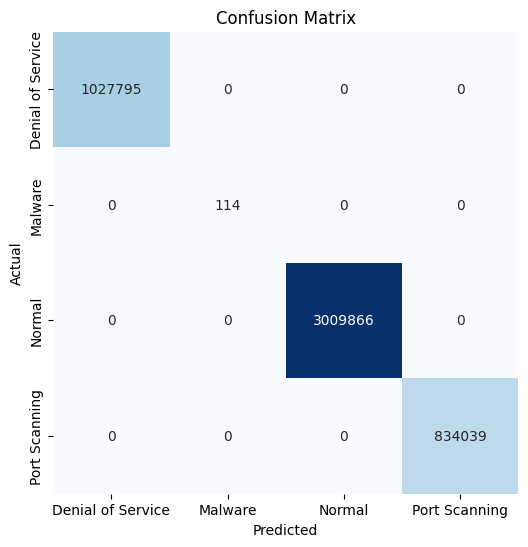

In [20]:
import numpy as np
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_730820/1430481780.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


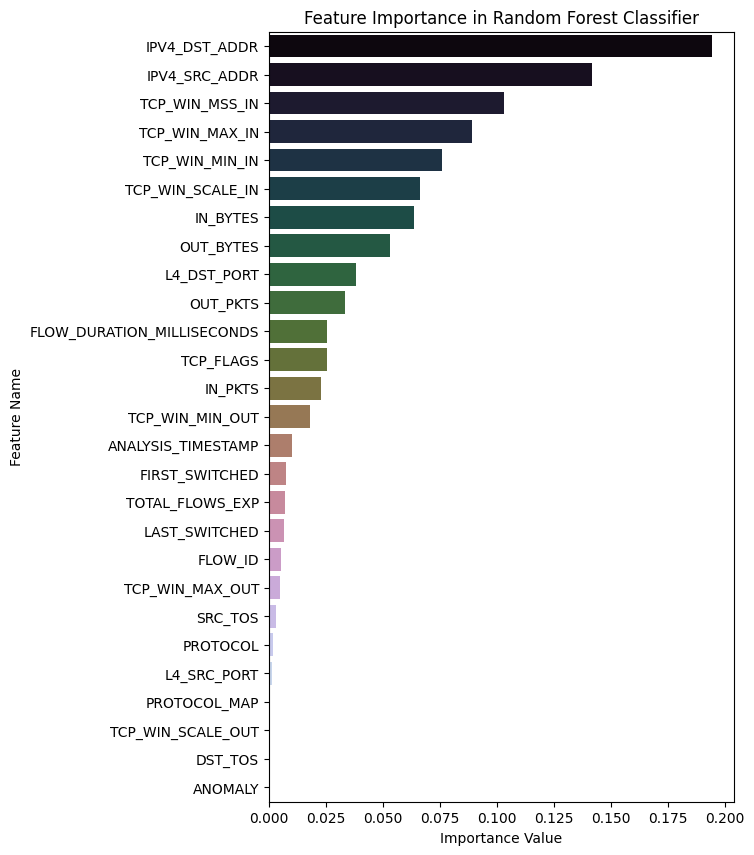

In [23]:
# Feature Importance
importance = rf_model.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(6, 10))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()